In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsBuilder
using ComponentArrays
using DFTK
using ForwardDiff
using LinearAlgebra
using Plots
using PseudoPotentialData
using Random
using Unitful
using UnitfulAtomic

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order (for SCF): the XC potential $V_\text{xc} = \frac{\partial E_\text{xc}}{\partial \rho}$, and
- second-order (for DFPT): the XC kernel $\frac{\partial V_\text{xc}}{\partial \rho}$, and the potential-parameter-derivative $\frac{\partial V_\text{xc}}{\partial \theta}$

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In [2]:
include("beef.jl")  # see this file for the BEEF functional implementation in few lines

Main.Beef

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

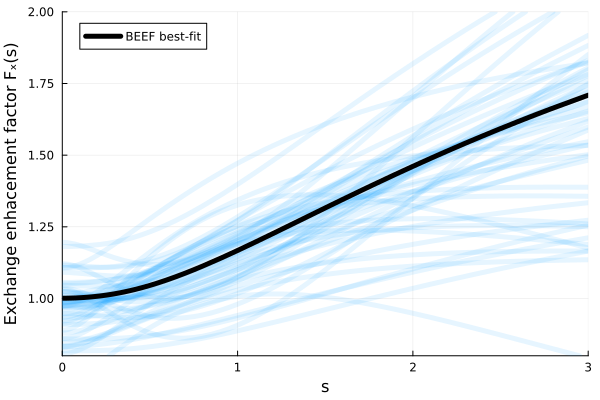

In [3]:
let 
    params = Beef.params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [4]:
params = Beef.params_beef_2005()
make_functionals(θ) = Beef.make_beef(θ)
functionals = make_functionals(params.θ_bf)

2-element Vector{DftFunctionals.Functional{:gga}}:
 gga_c_pbe
 gga_x_beef_custom

In [5]:
a0_beef = 10.328164895118894  # From a prior geometry relaxation
a0 = a0_beef
system = bulk(:Si; a=a0_beef * u"bohr")

# Set up DFT model
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
(; lattice, atoms, positions) = DFTK.parse_system(system, pseudopotentials)
model = model_DFT(lattice, atoms, positions; functionals, temperature=1e-3)
symmetries = model.symmetries

# Discretization
Ecut = recommended_cutoff(model).Ecut
kgrid = (8, 8, 8)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([8, 8, 8])
    num.   red. kpoints  : 512
    num. irred. kpoints  : 29

    Discretized Model(gga_c_pbe+gga_x_beef_custom, 3D):
        lattice (in Bohr)    : [0         , 5.16408   , 5.16408   ]
                               [5.16408   , 0         , 5.16408   ]
                               [5.16408   , 5.16408   , 0         ]
        unit cell volume     : 275.43 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.

In [6]:
scfres = self_consistent_field(basis; tol=1e-8);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450564937873                   -0.96    4.4    5.98s
  2   -8.452301969393       -2.76       -1.48    1.0    3.24s
  3   -8.452530205121       -3.64       -2.86    1.7    623ms
  4   -8.452557910914       -4.56       -3.23    3.2    670ms
  5   -8.452557974283       -7.20       -3.55    1.2    516ms
  6   -8.452557993082       -7.73       -4.21    1.4    790ms
  7   -8.452557995349       -8.64       -4.92    2.4    529ms
  8   -8.452557995465       -9.94       -5.21    2.3    866ms
  9   -8.452557995484      -10.72       -6.74    1.7    525ms
 10   -8.452557995485      -11.95       -6.72    4.4    1.61s
 11   -8.452557995485      -13.12       -7.14    1.0    580ms
 12   -8.452557995485      -13.41       -8.70    1.0    512ms


In [7]:
compute_stresses_cart(scfres)

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 9.76194e-7   0.0          0.0
 5.64689e-22  9.76194e-7   0.0
 0.0          5.64689e-22  9.76194e-7

## Computing XC parameter sensitivities by AD-DFPT

In [8]:
function setup_basis(a, θ; Ecut, kgrid)
    T = promote_type(eltype(a), eltype(θ))
    lattice_new = (a / a0) * lattice
    model_new = model_DFT(T.(lattice_new), atoms, positions;
                          functionals=make_functionals(θ), symmetries)
    basis_new = PlaneWaveBasis(model_new; Ecut, kgrid)
end

setup_basis (generic function with 1 method)

In [9]:
function hellmann_feynman_observables(a, θ; Ecut, kgrid, tol)
    # 1. Setup
    basis = setup_basis(a, θ; Ecut, kgrid)

    # 2. Solve
    scfres = self_consistent_field(basis; tol)

    # 3. Postprocess
    grads = ForwardDiff.gradient(ComponentVector(; a, θ)) do x
        basis_new = setup_basis(x.a, x.θ; Ecut, kgrid)
        ρ = compute_density(basis_new, scfres.ψ, scfres.occupation)
        (; energies) = DFTK.energy(basis_new, scfres.ψ, scfres.occupation;
                                   ρ, scfres.eigenvalues, scfres.εF)
        energies.total
    end

    grads
end

hellmann_feynman_observables (generic function with 1 method)

In [10]:
hellmann_feynman_observables(a0, params.θ_bf; Ecut, kgrid, tol=1e-6)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450461169210                   -0.96    4.3    2.63s
  2   -8.452388250151       -2.72       -1.81    1.0    1.15s
  3   -8.452550719327       -3.79       -2.90    2.1    599ms
  4   -8.452557919618       -5.14       -3.48    3.0    1.50s
  5   -8.452558007079       -7.06       -4.24    1.6    599ms
  6   -8.452558011404       -8.36       -5.20    2.2    729ms
  7   -8.452558011536       -9.88       -6.27    2.7    701ms


ComponentVector{Float64}(a = 7.818277828008924e-5, θ = [-2.6142645554778703, -0.2071483582641831, -0.022445213431821855])

In [11]:
hess = ForwardDiff.derivative(
    a -> hellmann_feynman_observables(a, params.θ_bf; Ecut, kgrid, tol=1e-6),
    a0
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450492248433                   -0.96    4.3    598ms
  2   -8.452397323560       -2.72       -1.81    1.0    341ms
  3   -8.452550178353       -3.82       -2.92    2.1    735ms
  4   -8.452557912120       -5.11       -3.43    3.0    899ms
  5   -8.452558005856       -7.03       -4.09    1.5    709ms
  6   -8.452558011301       -8.26       -5.22    2.0    1.32s
  7   -8.452558011536       -9.63       -5.80    3.0    909ms
  8   -8.452558011538      -11.74       -6.77    1.5    819ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      60.4   4.79s  Non-interacting
   1        0       1       -0.86     44.3   14.8s  
   2        0       2       -2.63     38.5   1.82s  
   3        0       3       -3.90     23.0   1.03s  
 

ComponentVector{Float64}(a = 0.07012569189785922, θ = [0.1502095526247038, -0.019620919297550082, -0.0056184801922994085])

In [12]:
lattice_constant_gradient = hess.a \ hess.θ  # Implicit derivative of relaxed lattice constant w.r.t. θ

3-element Vector{Float64}:
  2.142004571498415
 -0.2797964450194475
 -0.0801201391421983

## Predictive XC uncertainty in the lattice constant

We compute a linearized Gaussian pushfoward uncertainty
$$
\mathcal{N}(\theta_0, LL^\top) \to \mathcal{N}(a^\star(\theta_0), J LL^\top J^\top)
$$
where $J = \frac{\partial a^\star}{\partial\theta}\lvert_{\theta_0}$ is the implicit derivative of the lattice constant as a function of the XC parameters, evaluated at mean parameters $\theta_0$.

In [13]:
lattice_constant_uncertainty = norm(params.L'lattice_constant_gradient)

0.22814022990132857

In [14]:
a0_exp = austrip(5.422u"angstrom")

10.246095047720924

In [15]:
(a0 - a0_exp) / a0_exp

0.008009865906545966

In [16]:
println("Predicted lattice constant:    ", uconvert(u"angstrom", a0 * u"bohr"))
println("Experimental lattice constant: ", uconvert(u"angstrom", a0_exp * u"bohr"))
println("True error:                    ", uconvert(u"angstrom", (a0 - a0_exp) * u"bohr"))
println("Uncertainty estimate:          ", uconvert(u"angstrom", lattice_constant_uncertainty * u"bohr"))

Predicted lattice constant:    5.465429492945291 Å
Experimental lattice constant: 5.421999999999999 Å
True error:                    0.04342949294529222 Å
Uncertainty estimate:          0.12072661055395424 Å
 Å
Experimental lattice constant: 5.421999999999999 Å
True error:                    0.04342949294529222 Å
Uncertainty estimate:          0.12072661055395424 Å


## Propagating uncertainty to the band gap

In [17]:
function bandgap(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    ε = reduce(hcat, scfres.eigenvalues)
    # A coarse approximation to the band gap, only in the SCF kgrid (no interpolation)
    lumo = minimum(ε[ε .> scfres.εF])
    homo = maximum(ε[ε .≤ scfres.εF])
    lumo - homo
end

bandgap (generic function with 1 method)

In [18]:
uconvert(u"eV", bandgap(a0, params.θ_bf) * u"hartree")

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450505815587                   -0.96    4.3    934ms
  2   -8.452396266828       -2.72       -1.81    1.0    552ms
  3   -8.452549676116       -3.81       -2.91    2.0    975ms
  4   -8.452557915885       -5.08       -3.43    2.9    873ms
  5   -8.452558006436       -7.04       -4.08    1.4    865ms
  6   -8.452558011257       -8.32       -5.16    2.0    640ms
  7   -8.452558011535       -9.56       -5.62    3.0    1.44s
  8   -8.452558011538      -11.49       -6.72    1.4    531ms


0.6431143825767321 eV

In [19]:
bandgap_gradient = ForwardDiff.gradient(θ -> bandgap(a0, θ), params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450488804850                   -0.96    4.2    1.34s
  2   -8.452396072330       -2.72       -1.81    1.0    1.27s
  3   -8.452550221567       -3.81       -2.92    2.0    626ms
  4   -8.452557911320       -5.11       -3.44    3.1    1.11s
  5   -8.452558005867       -7.02       -4.10    1.5    869ms
  6   -8.452558011235       -8.27       -5.21    2.1    950ms
  7   -8.452558011537       -9.52       -5.88    2.9    1.07s
  8   -8.452558011538      -11.89       -6.83    1.6    545ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      60.3   1.59s  Non-interacting
   1        0       1       -1.47     44.7   2.58s  
   2        0       2       -2.82     31.9   2.31s  
   3        0       3       -3.97     19.9   1.57s  
 

3-element Vector{Float64}:
 0.05781187951284589
 0.02305951599886162
 0.007643280698477399

In [20]:
uconvert(u"eV", norm(params.L'bandgap_gradient) * u"hartree")

0.2379756111849267 eV

In [21]:
bandgap_gradient2 = ForwardDiff.derivative(a -> bandgap(a, params.θ_bf), a0)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450517015258                   -0.96    4.3    1.18s
  2   -8.452400858030       -2.72       -1.81    1.0    350ms
  3   -8.452550765440       -3.82       -2.91    2.1    789ms
  4   -8.452557920323       -5.15       -3.47    3.0    551ms
  5   -8.452558006975       -7.06       -4.18    1.6    481ms
  6   -8.452558011370       -8.36       -5.19    2.0    451ms
  7   -8.452558011537       -9.78       -6.18    2.9    539ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      56.8   2.15s  Non-interacting
   1        0       1       -0.86     40.5   1.89s  
   2        0       2       -2.63     34.5   1.93s  
   3        0       3       -3.90     18.9   1.06s  
   4        0       4       -5.21      7.1   742ms  
   5      

0.017707127129813233

Now this can be combined to the total gradient of the *equilibrium* band gap $E^\text{relaxed}_\text{gap}(\theta) := E_\text{gap}(a^\star(\theta), \theta)$ as
$$
\begin{align*}
\frac{\partial E^\text{relaxed}_\text{gap}}{\partial \theta}
=
\frac{\partial E_\text{gap}}{\partial \theta} + \frac{\partial E_\text{gap}}{\partial a} \frac{\partial a^\star}{\partial \theta}
\end{align*}
$$


In [22]:
bandgap_gradient_total = bandgap_gradient + bandgap_gradient2 * lattice_constant_gradient

3-element Vector{Float64}:
 0.09574062677300943
 0.018105124776432467
 0.006224583209028169

In [23]:
uconvert(u"eV", norm(params.L'bandgap_gradient_total) * u"hartree")

0.29349016409469797 eV

## Band structures

In [24]:
bands = compute_bands(scfres);
propertynames(bands)

(:basis, :ψ, :eigenvalues, :ρ, :εF, :occupation, :diagonalization, :kinter)

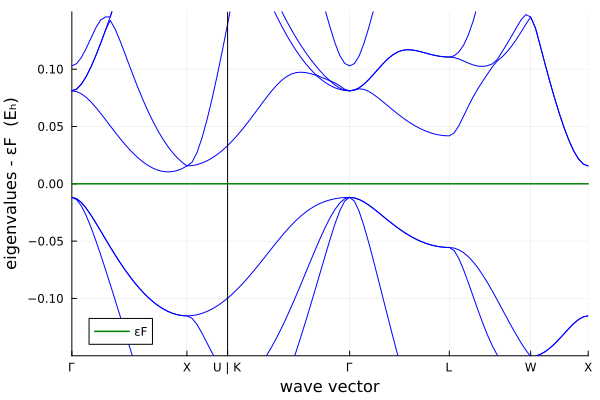

In [25]:
plot_bandstructure(bands)

To apply the same strategy as above, we are now interested in the derivative
of the whole band structure $\varepsilon_{n\mathbf{k}}$ with respect to parameters $\theta$.

In [26]:
include("compute_bands_forwarddiff.jl")

compute_bands_forwarddiff (generic function with 2 methods)

In [27]:
kgrid_bands = ExplicitKpoints(bands.kinter)

ExplicitKpoints with 109 k-points

In [151]:
function bandstructure(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    εF = DFTK.guess_fermi_level_intocc_(scfres.basis, scfres.eigenvalues)
    bands = compute_bands_forwarddiff(basis, kgrid_bands; scfres.ρ, tol=1e-6)
    @show εF
    reduce(hcat, bands.eigenvalues) .- εF
end

bandstructure (generic function with 1 method)

In [152]:
b = bandstructure(a0, params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450460718684                   -0.96    4.3    1.42s
  2   -8.452391023537       -2.71       -1.81    1.0    813ms
  3   -8.452550252966       -3.80       -2.90    2.1    813ms
  4   -8.452557915683       -5.12       -3.46    3.0    967ms
  5   -8.452558006849       -7.04       -4.17    1.6    811ms
  6   -8.452558011329       -8.35       -5.23    2.0    1.16s
  7   -8.452558011537       -9.68       -6.12    3.0    3.07s
εF = 0.16623960948474725


14×109 Matrix{Float64}:
 -0.446911   -0.446636   -0.445813   …  -0.296894   -0.297156   -0.297245
 -0.0118172  -0.0138152  -0.019425      -0.296894   -0.297156   -0.297245
 -0.0118172  -0.0130072  -0.0163548     -0.118312   -0.115996   -0.115181
 -0.0118172  -0.0130072  -0.0163548     -0.118312   -0.115996   -0.115181
  0.0810664   0.0803974   0.0784457      0.0215389   0.0171305   0.0156185
  0.0810664   0.0825957   0.0869606  …   0.0215389   0.0171305   0.0156185
  0.0810664   0.0825957   0.0869606      0.341754    0.349803    0.352234
  0.10285     0.104806    0.110237       0.341754    0.349803    0.352234
  0.270986    0.268752    0.26256        0.380114    0.386389    0.390026
  0.270986    0.271291    0.272206       0.380114    0.386389    0.390026
  0.279723    0.280938    0.284527   …   0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.475351    0.462962    0.459115
  0.399551    

In [153]:
dbands = ForwardDiff.jacobian(
    θ -> bandstructure(a0, θ),
    params.θ_bf
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450525092755                   -0.96    4.3    1.19s
  2   -8.452398875493       -2.73       -1.81    1.0    658ms
  3   -8.452550802381       -3.82       -2.91    2.1    803ms
  4   -8.452557915524       -5.15       -3.47    3.0    1.42s
  5   -8.452558006614       -7.04       -4.19    1.5    852ms
  6   -8.452558011373       -8.32       -5.22    2.1    824ms
  7   -8.452558011537       -9.79       -6.34    2.9    1.13s
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      57.3   2.35s  Non-interacting
   1        0       1       -1.47     41.5   2.35s  
   2        0       2       -2.82     28.7   1.78s  
   3        0       3       -3.97     16.0   1.34s  
   4        0       4       -5.26      7.4   1.39s  
   5      

1526×3 Matrix{Float64}:
 -0.00782222  -0.00187853   -0.00134435
 -0.0289059   -0.0115297    -0.00382163
 -0.0289059   -0.0115297    -0.00382163
 -0.0289059   -0.0115297    -0.00382163
  0.00253775   0.00359477   -0.00138107
  0.00253776   0.00359477   -0.00138107
  0.00253776   0.00359477   -0.00138107
 -0.0313636   -0.00505795   -0.00192744
  0.00471805   0.00320778   -0.00173582
  0.00471805   0.00320778   -0.00173582
  ⋮                         
  0.0334277    0.012884      0.00448136
 -0.0167542   -0.000171965  -0.00251238
 -0.0167542   -0.000171963  -0.00251238
 -0.00703838  -0.00626051   -0.000812894
 -0.00703838  -0.0062605    -0.000812893
  0.00131527   0.002485     -0.00198016
  0.00131527   0.002485     -0.00198016
 -0.00813214   0.000680044   0.00181265
 -0.00813214   0.000680042   0.00181265

In [154]:
dbands_reshaped = reshape(dbands, size(b)..., length(params.θ_bf))

14×109×3 Array{Float64, 3}:
[:, :, 1] =
 -0.00782222  -0.0078405   -0.00789533   …  -0.0190245    -0.0189765
 -0.0289059   -0.0289416   -0.0290323       -0.0190245    -0.0189765
 -0.0289059   -0.0283288   -0.0268406       -0.00931656   -0.00984095
 -0.0289059   -0.0283288   -0.0268406       -0.00931655   -0.00984095
  0.00253775   0.00290178   0.00393681       0.0328985     0.0334277
  0.00253776   0.00195613   0.000455627  …   0.0328985     0.0334277
  0.00253776   0.00195613   0.000455627     -0.016049     -0.0167542
 -0.0313636   -0.0313316   -0.0312158       -0.016049     -0.0167542
  0.00471805   0.00601782   0.00931507      -0.00655822   -0.00703838
  0.00471805   0.00471292   0.00469751      -0.00655822   -0.00703838
  0.0713859    0.0710179    0.0699713    …   0.000207897   0.00131527
  0.0513042    0.0512475    0.0510759        0.000207892   0.00131527
  0.0513042    0.0512475    0.0510759       -0.00821082   -0.00813214
  0.0513042    0.0506513    0.0492172       -0.00821082 

In [155]:
bands_uncertainty = [
    norm.(eachrow(dbands_reshaped[:,ik,:] * params.L))
    for ik in 1:size(b,2)
]

109-element Vector{Vector{Float64}}:
 [0.0019298666248097776, 0.0043727179733162955, 0.004372718051644362, 0.004372718163430441, 0.005561603056300667, 0.005561603108423943, 0.005561603024697766, 0.00358875297103399, 0.005812150328865394, 0.005812150122874526, 0.01695841925367518, 0.007503472274317921, 0.007503471885159719, 0.007503472389908167]
 [0.0019317843150404147, 0.004354300330630132, 0.004286693984924714, 0.004286694186531931, 0.0054811348937727445, 0.005470623803514155, 0.005470623838305356, 0.0035881601463116594, 0.005626576608986523, 0.005812311533328528, 0.016857700411306513, 0.007492905039253195, 0.007492903860969325, 0.0074194360420518106]
 [0.0019375421870573104, 0.004311900737335584, 0.004072324752153163, 0.004072324825385747, 0.005257107861869313, 0.005242576607862524, 0.005242576611754368, 0.003585312539874652, 0.005177762246108171, 0.00581279564523639, 0.016571332661938786, 0.007460930622132108, 0.007460930939358631, 0.00725374901798356]
 [0.00194712981238383, 0.00426

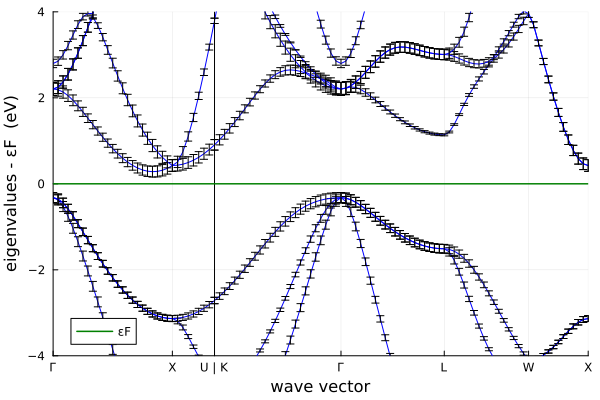

In [156]:
p1 = plot_bandstructure(
    (; bands..., eigenvalues_error=bands_uncertainty),
    unit=u"eV",
)

In [157]:
# TODO add total derivative of band structure w.r.t. θ (including implicit dependence via lattice constant)

In [158]:
# TODO visualize samples from the band distributions (to see smoothness/covariance)

In [159]:
dbands_a = ForwardDiff.derivative(a -> bandstructure(a, params.θ_bf), a0)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450484001281                   -0.96    4.2    1.04s
  2   -8.452391652291       -2.72       -1.81    1.0    861ms
  3   -8.452549213679       -3.80       -2.91    2.2    956ms
  4   -8.452557922981       -5.06       -3.45    2.8    1.03s
  5   -8.452558006223       -7.08       -4.10    1.5    860ms
  6   -8.452558011311       -8.29       -5.17    1.9    854ms
  7   -8.452558011535       -9.65       -5.64    3.0    1.11s
  8   -8.452558011538      -11.53       -6.68    1.3    697ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      60.0   2.42s  Non-interacting
   1        0       1       -0.86     43.8   3.60s  
   2        0       2       -2.63     37.8   3.23s  
   3        0       3       -3.90     22.4   1.64s  
 

14×109 Matrix{Float64}:
  0.0637894    0.0637205    0.0635142   …   0.0250666   0.0252638   0.0253299
 -0.00885357  -0.00997721  -0.0126156       0.0250666   0.0252637   0.02533
 -0.00885357  -0.00836178  -0.00703991      0.0209876   0.0197796   0.0193458
 -0.00885357  -0.00836178  -0.00703991      0.0209876   0.0197796   0.0193459
 -0.0128763   -0.0126904   -0.0121481       0.0101436   0.0116433   0.0121732
 -0.0128763   -0.0134476   -0.0150061   …   0.0101436   0.0116433   0.0121732
 -0.0128763   -0.0134476   -0.0150061      -0.0896136  -0.0968475  -0.0986849
 -0.128676    -0.127556    -0.124856       -0.0896136  -0.0968475  -0.0986849
 -0.0148388   -0.0142705   -0.0127805      -0.051444   -0.0450669  -0.0430278
 -0.0148388   -0.0149001   -0.0150839      -0.051444   -0.0450669  -0.0430278
 -0.0490982   -0.0493752   -0.0501893   …  -0.071846   -0.0554383  -0.0500873
 -0.043965    -0.0440493   -0.0442998      -0.071846   -0.0554384  -0.0500873
 -0.043965    -0.0440493   -0.0442998     

In [160]:
dbands_a[:, 1] * lattice_constant_gradient'

14×3 Matrix{Float64}:
  0.136637   -0.017848    -0.00511081
 -0.0189644   0.0024772    0.000709349
 -0.0189644   0.0024772    0.000709349
 -0.0189644   0.0024772    0.000709349
 -0.0275812   0.00360275   0.00103165
 -0.0275811   0.00360275   0.00103165
 -0.0275812   0.00360275   0.00103165
 -0.275625    0.0360031    0.0103095
 -0.0317847   0.00415184   0.00118889
 -0.0317847   0.00415184   0.00118888
 -0.105169    0.0137375    0.00393375
 -0.0941733   0.0123013    0.00352248
 -0.0941733   0.0123013    0.00352248
 -0.0941732   0.0123013    0.00352248

In [165]:
b

14×109 Matrix{Float64}:
 -0.446911   -0.446636   -0.445813   …  -0.296894   -0.297156   -0.297245
 -0.0118172  -0.0138152  -0.019425      -0.296894   -0.297156   -0.297245
 -0.0118172  -0.0130072  -0.0163548     -0.118312   -0.115996   -0.115181
 -0.0118172  -0.0130072  -0.0163548     -0.118312   -0.115996   -0.115181
  0.0810664   0.0803974   0.0784457      0.0215389   0.0171305   0.0156185
  0.0810664   0.0825957   0.0869606  …   0.0215389   0.0171305   0.0156185
  0.0810664   0.0825957   0.0869606      0.341754    0.349803    0.352234
  0.10285     0.104806    0.110237       0.341754    0.349803    0.352234
  0.270986    0.268752    0.26256        0.380114    0.386389    0.390026
  0.270986    0.271291    0.272206       0.380114    0.386389    0.390026
  0.279723    0.280938    0.284527   …   0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.450299    0.447599    0.44512
  0.399551    0.400029    0.401465       0.475351    0.462962    0.459115
  0.399551    

In [166]:
(dbands_reshaped[:,1,:] + dbands_a[:,1] * lattice_constant_gradient') * params.L

14×3 Matrix{Float64}:
  0.0116352    0.00249182  -0.00454361
 -0.00202089  -0.0047529    0.00155177
 -0.00202089  -0.0047529    0.00155177
 -0.00202089  -0.0047529    0.00155177
 -0.00819469   7.66492e-5   0.000900461
 -0.00819469   7.66496e-5   0.00090046
 -0.00819469   7.66492e-5   0.000900461
 -0.028658    -0.00982232   0.0106877
 -0.0088541   -1.74348e-5   0.000969597
 -0.0088541   -1.74345e-5   0.000969597
  0.00299973   0.007731     0.00149697
 -0.00690622   0.00461603   0.00170678
 -0.00690622   0.00461603   0.00170678
 -0.00690622   0.00461603   0.00170677

In [167]:
bands_uncertainty_total = [
    norm.(eachrow((dbands_reshaped[:,ik,:] + dbands_a[:,ik] * lattice_constant_gradient') * params.L))
    for ik in 1:size(b,2)
]

109-element Vector{Vector{Float64}}:
 [0.012737056251943353, 0.0053927770680118605, 0.005392777100151314, 0.005392777210801519, 0.008244369653472574, 0.008244368709535228, 0.008244369402445571, 0.03212458447248224, 0.008907045345550129, 0.00890704483487875, 0.008426607919805889, 0.00848036916990601, 0.008480368215085948, 0.008480367460578609]
 [0.012719983453156326, 0.0055626636988353835, 0.005266293107788757, 0.005266293218649211, 0.00811577499807078, 0.00828999194304434, 0.008289992051565396, 0.03184545643053242, 0.008568867146906571, 0.008920519707923945, 0.008322717572223545, 0.008499192994918293, 0.008499193521040962, 0.008565976291006056]
 [0.012668803820740553, 0.006003850547400969, 0.004932307102459777, 0.0049323069174073515, 0.007750664719821266, 0.008436855818255385, 0.008436855895345128, 0.03117289162942831, 0.007711330335576148, 0.008960960145589354, 0.008035696981508562, 0.008556227653978545, 0.008556227245009524, 0.00878067419295862]
 [0.012583478841546447, 0.006539691350

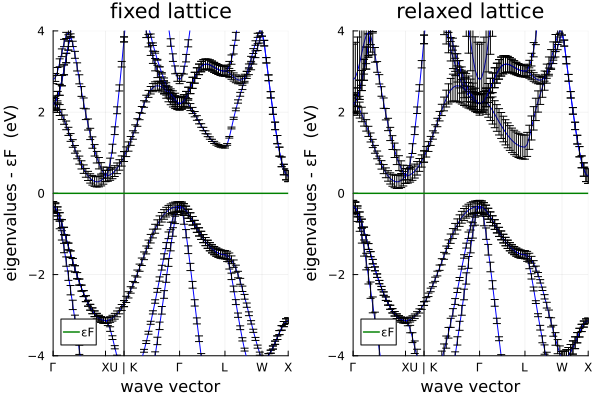

In [183]:
let
    p1 = plot_bandstructure(
        (; bands..., eigenvalues_error=bands_uncertainty),
        unit=u"eV",
    )
    p2 = plot_bandstructure(
        (; bands..., eigenvalues_error=bands_uncertainty_total),
        unit=u"eV",
    )

    # ylims = (-15, 10)
    # Plots.ylims!(p1, ylims)
    # Plots.ylims!(p2, ylims)
    plot(
        p1, p2,
        title = ["fixed lattice" "relaxed lattice"],
    )
end

## Sampling

n_bands = 14


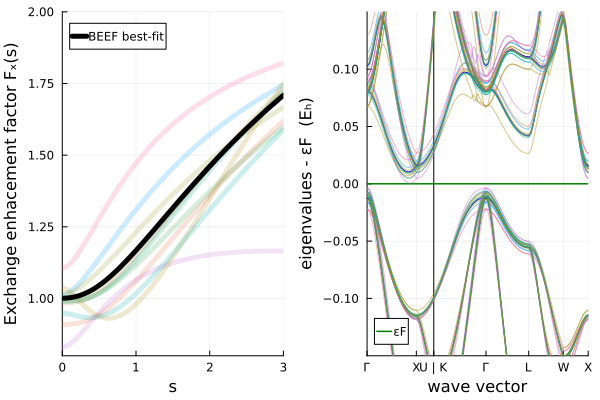

In [182]:
let 
    params = Beef.params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 10
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for (i, δθ) in enumerate(eachcol(δθ_ensemble))
        plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=i, 
        linealpha=0.2, 
        lw=5)
    end
    plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf), label="BEEF best-fit",
          linewidth=5, color=:black)

    p = plot_bandstructure(
        (; bands..., 
            # eigenvalues_error=bands_uncertainty_total
        ),
        plot_kwargs=(; color=:black)
        # unit=u"eV",
    )
    data = DFTK.data_for_plotting(bands)

    n_bands = size(dbands_reshaped, 1)
    @show n_bands

    for (i, δθ) in enumerate(eachcol(δθ_ensemble))
        # bands_sample = bands.eigenvalues + [
        #     dbands_reshaped[:,ik,:]*δθ + dbands_a[:,ik] * dot(lattice_constant_gradient, δθ) for ik in 1:size(b,2)
        # ]
        δa0 = dot(lattice_constant_gradient, δθ)
        for σ = 1:data.n_spin, iband = 1:n_bands, branch in data.kbranches
            energies = (data.eigenvalues[:, iband, σ][branch] .- bands.εF) + (
                dbands_reshaped[iband,branch,:]*δθ + dbands_a[iband,branch] * δa0
            )
            plot!(p, data.kdistances[branch], energies, label="", color=i, 
                linealpha=0.5
            )
        end
    end


    plot(fig_fx_ensemble, p, layout=(1,2))
end